# Outside the SDMX garden, looking at LEI and GLEIF

<img src="images/diagram_data.png" width="800" height="500"/>
<img src="images/use_case_diagram_start.png" width="800" height="500"/>



## Data cleaning and set up using pandas and pysdmx

<img src="images/diagram_first_step.png" width="800" height="500"/>


(Check the full notebook for the code to download the data)

In [6]:
#2. Read the downloaded data with Pandas
import pandas as pd

file_name = '20250125-1600-gleif-goldencopy-lei2-golden-copy.csv'

# We will read only the first 10000 rows as a sample
data = pd.read_csv('data_files/' + file_name, dtype=str, nrows=10000)
display(data)

,LEI,Entity.LegalName,Entity.LegalName.xmllang,Entity.OtherEntityNames.OtherEntityName.1,Entity.OtherEntityNames.OtherEntityName.1.xmllang,Entity.OtherEntityNames.OtherEntityName.1.type,Entity.OtherEntityNames.OtherEntityName.2,Entity.OtherEntityNames.OtherEntityName.2.xmllang,Entity.OtherEntityNames.OtherEntityName.2.type,Entity.OtherEntityNames.OtherEntityName.3,...,Registration.OtherValidationAuthorities.OtherValidationAuthority.3.ValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.3.OtherValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.3.ValidationAuthorityEntityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.4.ValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.4.OtherValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.4.ValidationAuthorityEntityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.5.ValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.5.OtherValidationAuthorityID,Registration.OtherValidationAuthorities.OtherValidationAuthority.5.ValidationAuthorityEntityID,ConformityFlag
0,001GPB6A9XPE8XJICC14,Fidelity Advisor Leveraged Company Stock Fund,en,FIDELITY ADVISOR SERIES I - Fidelity Advisor L...,en,PREVIOUS_LEGAL_NAME,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
1,004L5FPTUREIWK9T2N63,"Hutchin Hill Capital, LP",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NON_CONFORMING
2,00EHHQ2ZHDCFXJCPCL46,Vanguard Russell 1000 Growth Index Trust,en-US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
3,00GBW0Z2GYIER7DHDS71,"ARISTEIA CAPITAL, L.L.C.",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
4,00KLB2PFTM3060S2N216,Oakmark International Fund,en,HARRIS ASSOCIATES INVESTMENT TRUST - Oakmark I...,en,PREVIOUS_LEGAL_NAME,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21380012PY96FUKPP805,ITELA HOLDING AS,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
9996,21380012Q6KHP17Q4K39,JOSEPH WALTER CHAMBERLAIN DIS,en,JOSEPH WALTER CHAMBERLAIN DISCRETIONARY,en,TRADING_OR_OPERATING_NAME,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NON_CONFORMING
9997,21380012QLF2BOUUZA18,R W ARMSTRONG & SONS LIMITED RETIREMENT AND DE...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING
9998,21380012QWUG4B14Y756,ORIENTAL HARBOR INVESTMENT FUND,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFORMING


In [7]:
#3. Drop the columns not used in the DSD and rename the existing ones

RENAME_DICT = {
    "LEI": "LEI",
    "Entity.LegalName": "LEGAL_NAME",
    "Entity.LegalAddress.Country": "COUNTRY_INCORPORATION",
    "Entity.HeadquartersAddress.Country": "COUNTRY_HEADQUARTERS",
    "Entity.EntityCategory": "CATEGORY",
    "Entity.EntitySubCategory": "SUBCATEGORY",
    "Entity.LegalForm.EntityLegalFormCode": "LEGAL_FORM",
    "Entity.EntityStatus": "STATUS",
    "Entity.LegalAddress.PostalCode": "POSTAL_CODE",
}

data.rename(columns=RENAME_DICT, inplace=True)
data = data[list(RENAME_DICT.values())]

# 4. Data filtering by status
data = data[data['STATUS'] == 'ACTIVE'].reset_index(drop=True)
del data['STATUS']
display(data)

,LEI,LEGAL_NAME,COUNTRY_INCORPORATION,COUNTRY_HEADQUARTERS,CATEGORY,SUBCATEGORY,LEGAL_FORM,POSTAL_CODE
0,001GPB6A9XPE8XJICC14,Fidelity Advisor Leveraged Company Stock Fund,US,US,FUND,NaN,8888,02210
1,004L5FPTUREIWK9T2N63,"Hutchin Hill Capital, LP",US,US,GENERAL,NaN,T91T,19808
2,00EHHQ2ZHDCFXJCPCL46,Vanguard Russell 1000 Growth Index Trust,US,US,FUND,NaN,8888,19355
3,00GBW0Z2GYIER7DHDS71,"ARISTEIA CAPITAL, L.L.C.",US,US,GENERAL,NaN,HZEH,19801
4,00KLB2PFTM3060S2N216,Oakmark International Fund,US,US,FUND,NaN,8888,02110
...,...,...,...,...,...,...,...,...
9549,21380012PY96FUKPP805,ITELA HOLDING AS,NO,NO,GENERAL,NaN,YI42,0191
9550,21380012Q6KHP17Q4K39,JOSEPH WALTER CHAMBERLAIN DIS,GB,GB,GENERAL,NaN,8888,BS2 0PT
9551,21380012QLF2BOUUZA18,R W ARMSTRONG & SONS LIMITED RETIREMENT AND DE...,GB,GB,GENERAL,NaN,8888,RG26 5RU
9552,21380012QWUG4B14Y756,ORIENTAL HARBOR INVESTMENT FUND,KY,HK,GENERAL,NaN,MPUG,KY1-1206


# Retrieving the Schema from FMR and generate the Dataset
<img src="images/diagram_second_step.png" width="800" height="500"/>


In [8]:
from pysdmx.api.fmr import RegistryClient
from pysdmx.io.format import StructureFormat
from pysdmx.io.pd import PandasDataset

client = RegistryClient(
    "https://fmr.meaningfuldata.eu/sdmx/v2", format=StructureFormat.FUSION_JSON
)
# Recommend to use debugger to see the response
schema = client.get_schema(
    "datastructure", agency="MD", id="LEI_DATA", version="1.0"
)
# Generate the PandasDataset
dataset = PandasDataset(structure=schema, data=data)
schema.short_urn

'datastructure=MD:LEI_DATA(1.0)'

# Structural validation using FMR

In [9]:
# Code to validate the dataset on FMR
from utils import validate_data_fmr
from pysdmx.io.csv.sdmx20.writer import write

# Serialization on SDMX-CSV 2.0
csv_text = write([dataset])

# Validate using FMR
result = validate_data_fmr(csv_text, host="fmr.meaningfuldata.eu", port=443,
                           use_https=True)
result

[]

# Using VTL to validate the data with GLEIF data quality checks

<img src="images/diagram_third_step.png" width="800" height="500"/>


## Validate the data using VTL

(See validations VTL Script)

Running the VTL script

In [10]:
from utils import _load_script, run_vtl

script = _load_script("vtl/validations.vtl")
validations_result = run_vtl(script=script, dataset=dataset)

Getting the total number of errors

In [11]:
validations_result['errors_count'].data

,errorlevel,int_var
0,3,47
1,1,4


Analysing data on Postal Code errors

In [12]:
cols_to_analyse = ['LEI','COUNTRY_INCORPORATION', 'POSTAL_CODE', 'errorcode',
                   'errorlevel']
display(validations_result['validation.postal_codes_errors'].data[cols_to_analyse])

,LEI,COUNTRY_INCORPORATION,POSTAL_CODE,errorcode,errorlevel
0,097900BEJQ0000001904,BG,100 0,pc15,3
1,097900BFDY0000022323,BG,160 6,pc15,3
2,097900BFIM0000031682,BG,140 4,pc15,3
3,097900BGHM0000045162,BG,900 0,pc15,3
4,097900BGJU0000050975,BG,900 0,pc15,3
5,097900BGK00000052654,BG,157 4,pc15,3
6,097900BGKE0000050836,BG,100 0,pc15,3
7,097900BGKV0000052913,BG,100 0,pc15,3
8,097900BGKV0000053010,BG,161 2,pc15,3
9,097900BGKY0000053639,BG,158 2,pc15,3


Filtering the data to remove the errors

In [13]:
leis_to_delete = validations_result['validation.postal_codes_errors'].data['LEI']
valid_data = dataset.data[~dataset.data['LEI'].isin(leis_to_delete)].reset_index(drop=True)
print(f"Number of LEIs removed: {len(leis_to_delete)}")
print(f"Number of LEIs remaining: {len(valid_data)}")

Number of LEIs removed: 47
Number of LEIs remaining: 9507


## Using VTL to perform calculations

<img src="images/diagram_fourth_step.png" width="800" height="500"/>


(See calculations.vtl)

Running the VTL script on all data

In [14]:
script = _load_script("vtl/calculations.vtl")
all_dataset = PandasDataset(structure=schema, data=pd.read_csv('data_files/golden_copy_changed.csv', dtype=str))

calculations_result = run_vtl(script=script, dataset=all_dataset)
display(calculations_result['lei_statistics'].data)

,COUNTRY,OBS_VALUE,TYPE_MEASURE
0,US,301541,NUMBER_INCORPORATED_ENTITIES
1,CZ,26333,NUMBER_INCORPORATED_ENTITIES
2,CA,48496,NUMBER_INCORPORATED_ENTITIES
3,KY,38287,NUMBER_INCORPORATED_ENTITIES
4,IE,29017,NUMBER_INCORPORATED_ENTITIES
...,...,...,...
634,KI,1,NUMBER_ENTITIES_DIFF_HQ
635,BA,1,NUMBER_ENTITIES_DIFF_HQ
636,SV,1,NUMBER_ENTITIES_DIFF_HQ
637,AD,1,NUMBER_ENTITIES_DIFF_HQ


# Diagram on aggregated statistics

<Figure size 640x480 with 0 Axes>

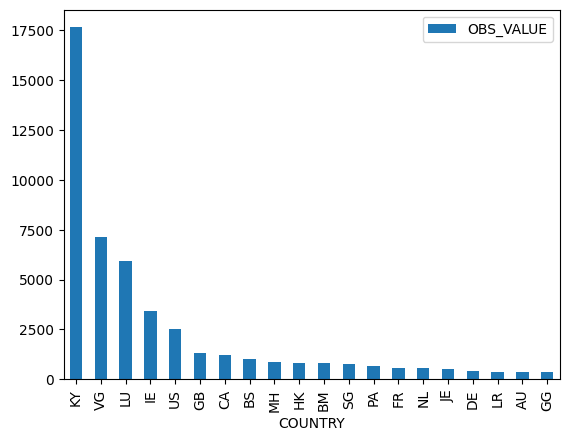

In [20]:
import matplotlib.pyplot as plt

df = data[data['TYPE_MEASURE'] == 'NUMBER_ENTITIES_DIFF_HQ']
df = df.astype({'OBS_VALUE': int})

plt.figure()
df.nlargest(columns='OBS_VALUE', n=20).plot(x='COUNTRY', y='OBS_VALUE', kind='bar')
plt.show()

The countries with the most LEIs with the HQ in a different country
than the incorporation is Cayman Islands, Virgin Islands and Luxembourg

# Generate PandasDataset with the aggregated data

In [21]:
from pysdmx.io import read_sdmx
from pysdmx.io.pd import PandasDataset

# Reading SDMX-ML 2.1 Message
msg = read_sdmx(
    "https://fmr.meaningfuldata.eu/sdmx/v2/structure/datastructure/MD/LEI_AGGREGATE_STATISTICS/+/?format=sdmx-2.1&references=descendants&prettyPrint=true")

# Extracting DataStructureDefinition MD:LEI_AGGREGATE_STATISTICS(1.0)
dsd = msg.get_data_structure_definition(
    "DataStructure=MD:LEI_AGGREGATE_STATISTICS(1.0)")
schema_aggregated = dsd.to_schema()

# Generating the dataset
data = calculations_result['lei_statistics'].data
pd_dataset = PandasDataset(structure=schema_aggregated, data=data)
display(pd_dataset.data)

,COUNTRY,OBS_VALUE,TYPE_MEASURE
0,US,301541,NUMBER_INCORPORATED_ENTITIES
1,CZ,26333,NUMBER_INCORPORATED_ENTITIES
2,CA,48496,NUMBER_INCORPORATED_ENTITIES
3,KY,38287,NUMBER_INCORPORATED_ENTITIES
4,IE,29017,NUMBER_INCORPORATED_ENTITIES
...,...,...,...
634,KI,1,NUMBER_ENTITIES_DIFF_HQ
635,BA,1,NUMBER_ENTITIES_DIFF_HQ
636,SV,1,NUMBER_ENTITIES_DIFF_HQ
637,AD,1,NUMBER_ENTITIES_DIFF_HQ


# Write the SDMX-ML 2.1 file

<img src="images/diagram_fifth_step.png" width="800" height="500"/>


In [17]:
from pysdmx.io.xml.sdmx21.writer.structure_specific import write

xml_str = write([pd_dataset], prettyprint=True)

print(xml_str)

<?xml version="1.0" encoding="UTF-8"?>
<mes:StructureSpecificData xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:mes="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message" xmlns:ss="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/structurespecific" xmlns:com="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common" xmlns:ns1="urn:sdmx:org.sdmx.infomodel.datastructure.datastructure=MD:LEI_AGGREGATE_STATISTICS(1.0):ObsLevelDim:AllDimensions" xsi:schemaLocation="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message https://registry.sdmx.org/schemas/v2_1/SDMXMessage.xsd">
	<mes:Header>
		<mes:ID>1f8aaeb0-d98d-4a8a-a35f-0df471e3569b</mes:ID>
		<mes:Test>true</mes:Test>
		<mes:Prepared>2025-01-27T19:16:19</mes:Prepared>
		<mes:Sender id="ZZZ"/>
		<mes:Structure structureID="LEI_AGGREGATE_STATISTICS" namespace="urn:sdmx:org.sdmx.infomodel.datastructure.DataStructure==MD:LEI_AGGREGATE_STATISTICS(1.0)" dimensionAtObservation="AllDimensions">
			<com:Structure>
				